## Customer Analytics

This notebooks aims to provide analytics on customer segments and purchasing patterns.

I have made some assumption in my analysis to provide context for the insights. Where such assumptions are present, I have mentioned them before the analysis.

The data is from [Kaggle](https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset).

In [1]:
# Required Libraries
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.ticker as mticker
plt.style.use('ggplot') 

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.options.display.float_format = '{:.2f}'.format 
pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.set_option('display.max_colwidth', None)

In [2]:
# Read the dataset

data = pd.read_csv('../customer_shopping_data.csv')
data.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [3]:
# convert invoice date to datetime format
data['invoice_date'] = pd.to_datetime(data['invoice_date'])

# create year and month columns from invoice date
data['invoice_year'] = data['invoice_date'].dt.year
data['invoice_month'] = data['invoice_date'].dt.strftime('%B')

# create total revenue column
data['total_revenue'] = data['quantity'] * data['price']
data.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,invoice_year,invoice_month,total_revenue
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-05-08,Kanyon,2022,May,7502.00
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,2021,December,5401.53
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-09-11,Metrocity,2021,September,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,2021,May,15004.25
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,2021,October,242.40


In [4]:
# HELPER FUNCTIONS

def format_revenue_with_thousand_separator(x):
    """
        function to format the revenue values with thousand separators
    """
    return "${:,.2f}".format(x)

## Customer Insights

### 1. What is the age distribution of male and female customers?

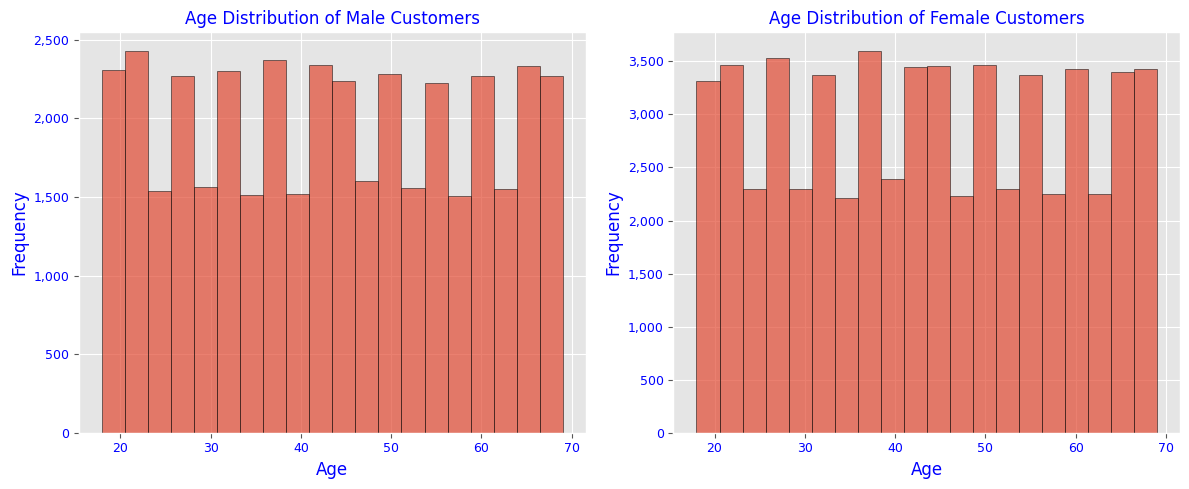

In [5]:
# Male and female groups
male_data = data[data['gender'] == 'Male']
female_data = data[data['gender'] == 'Female']

# Histograms for male and female age distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(male_data['age'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Age Distribution of Male Customers', color='blue',fontsize=12)
plt.xlabel('Age',color='blue',fontsize=12)
plt.ylabel('Frequency',color='blue',fontsize=12)
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.subplot(1, 2, 2)
plt.hist(female_data['age'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Age Distribution of Female Customers',color='blue',fontsize=12)
plt.xlabel('Age',color='blue',fontsize=12)
plt.ylabel('Frequency',color='blue',fontsize=12)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

**Observation:** The distribution of the age of male and female customers is the same.

### 2. Is there a significant difference between age of male and female customers

In [6]:
# Hypothesis
H0 = "There is a significant age difference between male and female customers."
H1 = "There is no significant age difference between male and female customers."

# Male and female groups
male_data = data[data['gender'] == 'Male']['age']
female_data = data[data['gender'] == 'Female']['age']

# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(male_data, female_data, equal_var=False)

# Set significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print(H0)
else:
    print(H1)

There is no significant age difference between male and female customers.


### 3. Are there more male or female customers in each age group?

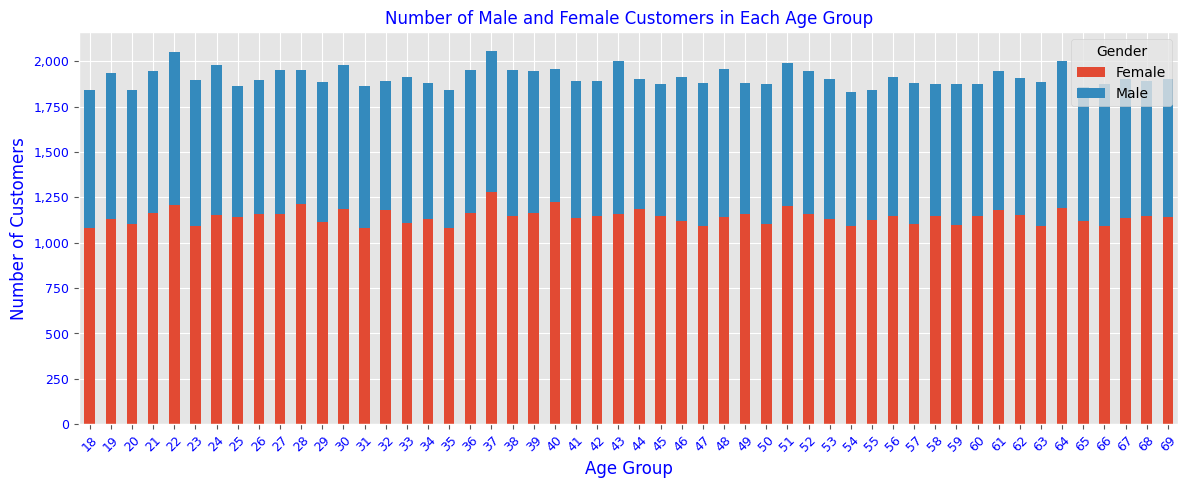

In [7]:
# Group data by age and gender
age_gender_counts = data.groupby(['age', 'gender']).size().unstack()

# Plot stacked bar plot
age_gender_counts.plot(kind='bar', stacked=True, figsize=(12, 5))
plt.title('Number of Male and Female Customers in Each Age Group', color='blue', fontsize=12)
plt.xlabel('Age Group',color='blue', fontsize=12)
plt.ylabel('Number of Customers',color='blue', fontsize=12)
plt.legend(title='Gender')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

**Observation**: There are more female customers than male in each age group.

### 4. How many new customers were acquired in the last quarter?

In [8]:
# start and end dates of the last quarter
end_date = datetime(2023, 6, 30)
start_date = end_date - timedelta(days=90)

# customers who made their first purchase within the last quarter
first_purchase_dates = data.groupby('customer_id')['invoice_date'].min()
new_customers_last_quarter = first_purchase_dates[
    (first_purchase_dates >= start_date) & (first_purchase_dates <= end_date)]

num_customers_acquired = len(new_customers_last_quarter)
print("Number of new customers acquired in the last quarter:", format(num_customers_acquired,','))

Number of new customers acquired in the last quarter: 1,180


### 5. What is the average age of customers who make high-value purchases?

**ASSUMPTION**: The assumption here is that 2000 or more is a high value purchase

In [9]:
# high-value purchases
high_value_threshold = 2000 
high_value_customers = data[data['total_revenue'] >= high_value_threshold]

# average age of customers making high-value purchases
average_age_high_value = high_value_customers['age'].mean()
average_age_high_value = round(average_age_high_value,2)

print("Average age of customers making high-value purchases:", average_age_high_value)

Average age of customers making high-value purchases: 43.49


### 6. What is the mean age of customers for each quartile of total sales

In [10]:
# total sales for each customer
data['total_revenue'] = data['quantity'] * data['price']
customer_total_sales = data.groupby('customer_id')['total_revenue'].sum()

# Customer quartiles
quartile_labels = ['Q1', 'Q2', 'Q3', 'Q4']
customer_total_sales_df = pd.DataFrame(customer_total_sales)
customer_total_sales_df['quartile'] = pd.qcut(customer_total_sales_df['total_revenue'], q=4, labels=quartile_labels)

customer_ages = data[['customer_id', 'age']].drop_duplicates()
customer_quartiles = customer_total_sales_df.merge(customer_ages, left_index=True, right_on='customer_id')

# mean age for each quartile
mean_age_per_quartile = customer_quartiles.groupby('quartile')['age'].mean().reset_index()

print("Mean age of customers for each quartile of total sales:\n")

print(mean_age_per_quartile)

Mean age of customers for each quartile of total sales:

  quartile   age
0       Q1 43.49
1       Q2 43.30
2       Q3 43.45
3       Q4 43.47


### 7. What is the average spending of customers aged 30-40?

In [11]:
# average spending for customers aged 30-40
customers_age_30_40 = data[(data['age'] >= 30) & (data['age'] <= 40)]
average_spending_30_40 = customers_age_30_40['total_revenue'].mean()
average_spending_30_40 = round(average_spending_30_40,2)

print(f"Average spending of customers aged 30-40: ${average_spending_30_40:,.2f}")

Average spending of customers aged 30-40: $2,509.64


### 8. Are there any correlations between customer age and payment methods?

In [12]:
# Calculate the correlation matrix
payment_methods_encoded = pd.get_dummies(data['payment_method'], prefix='payment')

data_with_encoded_payment = pd.concat([data, payment_methods_encoded], axis=1)

correlation_matrix = data_with_encoded_payment[['age', 'payment_Credit Card', 'payment_Debit Card', 'payment_Cash']].corr()

correlation_age_payment_method = correlation_matrix['age'][1:]

print("Correlation between customer age and payment methods:\n")

print(correlation_age_payment_method)

Correlation between customer age and payment methods:

payment_Credit Card    0.00
payment_Debit Card    -0.00
payment_Cash           0.00
Name: age, dtype: float64


### 9. Who are the top 10 customers in terms of lifetime spending?

In [13]:
# total spending for each customer
customer_total_spending = data.groupby('customer_id')['total_revenue'].sum().reset_index()

# get the top 10
top_10_customers = customer_total_spending.sort_values('total_revenue',ascending=False).head(10)
top_10_customers['total_revenue'] = top_10_customers['total_revenue'].apply(format_revenue_with_thousand_separator)
print("Top 10 customers in terms of lifetime spending:\n")
print(top_10_customers)

Top 10 customers in terms of lifetime spending:

      customer_id total_revenue
11798     C137763    $26,250.00
88377     C699580    $26,250.00
3332      C110600    $26,250.00
3340      C110625    $26,250.00
34854     C211345    $26,250.00
12314     C139344    $26,250.00
88400     C700083    $26,250.00
60015     C291511    $26,250.00
60052     C291627    $26,250.00
20130     C164347    $26,250.00


### 10. What is the average spending of customers who shop in the shopping malls?

In [14]:
# average spending for customers in the specific malls

average_spending_malls = \
            data.groupby('shopping_mall')['total_revenue'].mean().reset_index()

average_spending_malls['total_revenue'] = \
            average_spending_malls['total_revenue'].apply(format_revenue_with_thousand_separator)

average_spending_malls = average_spending_malls.sort_values('total_revenue',ascending=False)

print("Average spending of customers in the shopping malls:\n")
print(average_spending_malls)

Average spending of customers in the shopping malls:

       shopping_mall total_revenue
1  Emaar Square Mall     $2,578.69
5   Mall of Istanbul     $2,550.89
4             Kanyon     $2,550.28
8     Viaport Outlet     $2,548.10
9       Zorlu Center     $2,542.08
0        Cevahir AVM     $2,533.59
3       Istinye Park     $2,517.01
7       Metropol AVM     $2,497.78
2     Forum Istanbul     $2,487.15
6          Metrocity     $2,485.03


### 11. Are there any noticeable patterns in the distribution of customer ages across shopping malls?

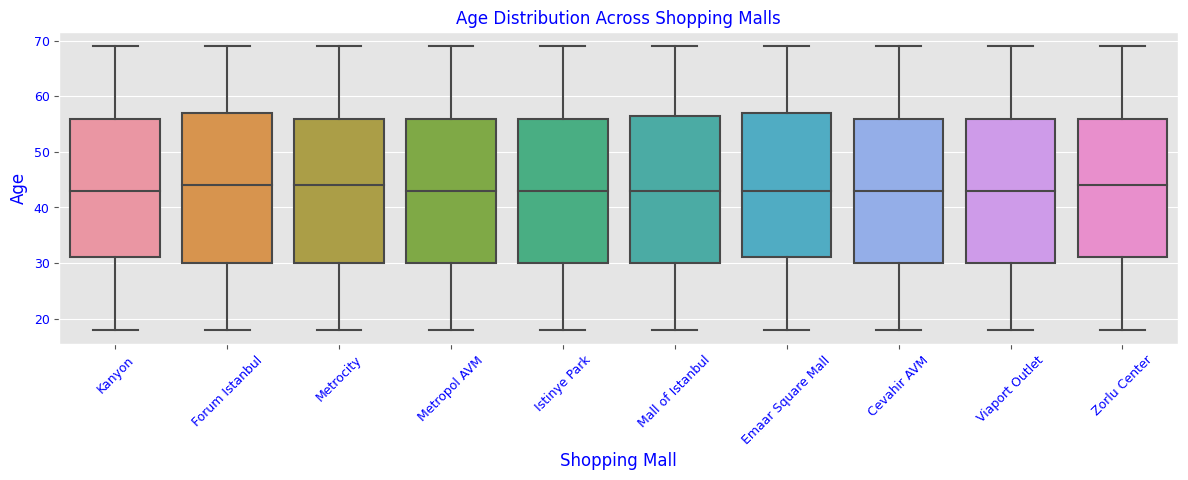

In [15]:
# age distribution across shopping malls
plt.figure(figsize=(12, 5)) 

sns.boxplot(x='shopping_mall', y='age', data=data)
plt.title('Age Distribution Across Shopping Malls', color='blue', fontsize=12)
plt.xlabel('Shopping Mall',color='blue', fontsize=12)
plt.ylabel('Age',color='blue', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

**Observation**: There is no noticeable patterns in the distribution of customer ages across the shopping mall. The average age of the customers is seamingly the same.

### 12. How has the customer base grown or shifted over the past year?

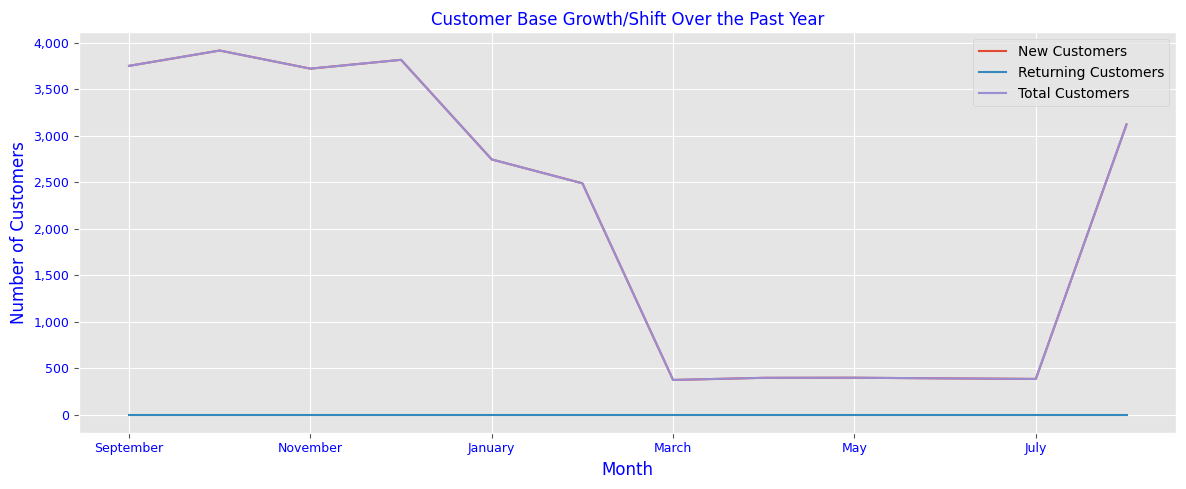

In [16]:
# data for the past year
end_date = pd.to_datetime('2023-08-10')
start_date = end_date - pd.DateOffset(years=1)

past_year_data = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]

monthly_customer_counts = past_year_data.groupby(['invoice_month', 'customer_id']).size().reset_index(name='count')

# month order
month_order = [
    'September', 'October', 'November', 'December', 'January', 'February',
    'March', 'April', 'May', 'June', 'July', 'August']

monthly_customer_counts['invoice_month'] = pd.Categorical(monthly_customer_counts['invoice_month'], 
                                categories=month_order, ordered=True)

# new and returning customers for each month
customer_acquisition = monthly_customer_counts.groupby('invoice_month')['customer_id'].nunique()
customer_retention = monthly_customer_counts.groupby('invoice_month').apply(lambda x: (x['count'] > 1).sum())

# total customers in each month (new + returning)
total_customers = customer_acquisition + customer_retention

# Plot growth/shift of the customer base over the past year
plt.figure(figsize=(12, 5))

customer_acquisition.plot(label='New Customers')
customer_retention.plot(label='Returning Customers')
total_customers.plot(label='Total Customers')

plt.title('Customer Base Growth/Shift Over the Past Year',color='blue', fontsize=12)
plt.xlabel('Month',color='blue', fontsize=12)
plt.ylabel('Number of Customers',color='blue', fontsize=12)
plt.legend()
plt.xticks(rotation=0)

plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

**Observation**: 
    
- Since the data has no repeat customer, its difficult to determine a shift/growth in customer base. However, from the analysis, there was a decrease in new customers from December last year to July this year. Additionally, there has been a significant growth of new customers in August this year.

### 13. How do the purchasing patterns of young female customers differ from those of older male customers?

**ASSUMPTION**: The assumption here is that 30 years is the cap for 'young' customers.

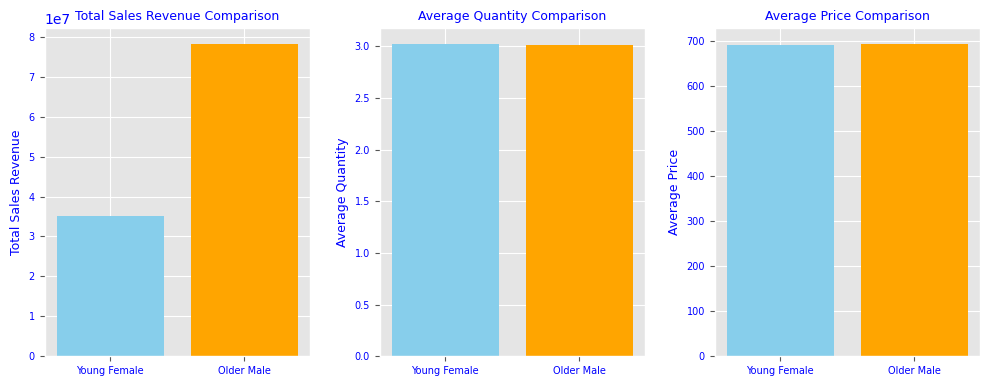

In [17]:
# young female customers & old male customers
young_female_data = data[(data['age'] < 30) & (data['gender'] == 'Female')]
older_male_data = data[(data['age'] >= 30) & (data['gender'] == 'Male')]

# total sales revenue for young female and older male customers
total_revenue_young_female = young_female_data['total_revenue'].sum()
total_revenue_older_male = older_male_data['total_revenue'].sum()

# average quantity and average price for each group
average_quantity_young_female = young_female_data['quantity'].mean()
average_price_young_female = young_female_data['price'].mean()
average_quantity_older_male = older_male_data['quantity'].mean()
average_price_older_male = older_male_data['price'].mean()

# bar plots to compare purchasing patterns
plt.figure(figsize=(10, 4))

# Total sales revenue comparison
plt.subplot(1, 3, 1)
plt.bar(['Young Female', 'Older Male'], [total_revenue_young_female, total_revenue_older_male], color=['skyblue', 'orange'])
plt.title("Total Sales Revenue Comparison",color='blue', fontsize=9)
plt.ylabel("Total Sales Revenue",color='blue', fontsize=9)
plt.tight_layout()
plt.tick_params(axis='x', which='both', labelsize=7, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=7, labelcolor='blue')

# Average quantity comparison
plt.subplot(1, 3, 2)
plt.bar(['Young Female', 'Older Male'], [average_quantity_young_female, average_quantity_older_male], color=['skyblue', 'orange'])
plt.title("Average Quantity Comparison", color='blue', fontsize=9)
plt.ylabel("Average Quantity",color='blue', fontsize=9)
plt.tight_layout()
plt.tick_params(axis='x', which='both', labelsize=7, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=7, labelcolor='blue')

# Average price comparison
plt.subplot(1, 3, 3)
plt.bar(['Young Female', 'Older Male'], [average_price_young_female, average_price_older_male], color=['skyblue', 'orange'])
plt.title("Average Price Comparison",color='blue', fontsize=9)
plt.ylabel("Average Price",color='blue', fontsize=9)

plt.tight_layout()
plt.tick_params(axis='x', which='both', labelsize=7, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=7, labelcolor='blue')
plt.show()

**Observations**:
    
- Older male contributed to more sales revenue that young females.

- Average quantity for both categories was the same.

- Average price for the products purchased by both categories were the same.

### 14. How do customers' purchasing habits change as they age?

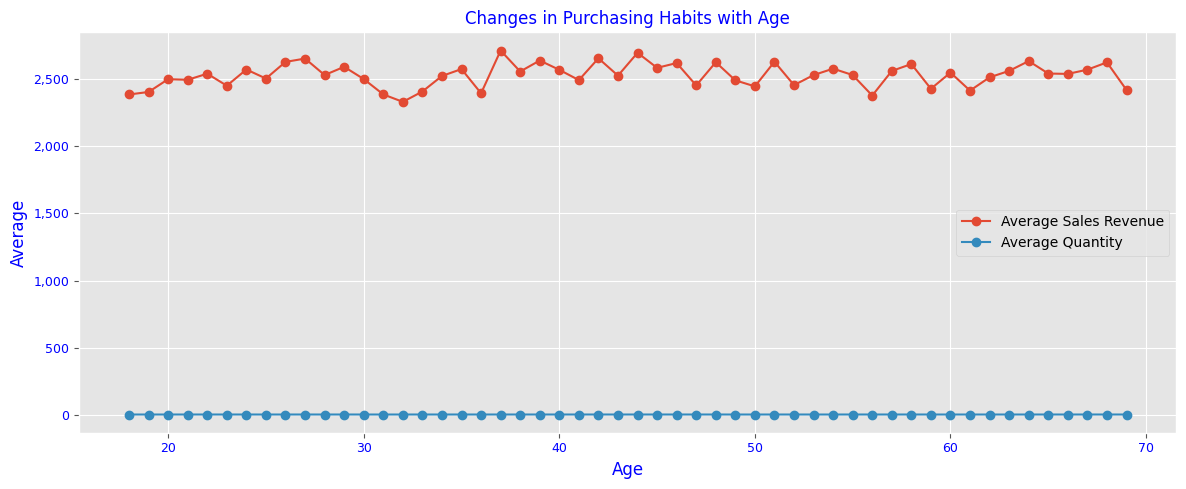

In [18]:
# average sales revenue and quantity for each age group
age_group_data = data.groupby('age')['total_revenue', 'quantity'].mean().reset_index()

# Create a line plot to visualize the changes in purchasing habits with age
plt.figure(figsize=(12, 5))
plt.plot(age_group_data['age'], age_group_data['total_revenue'], marker='o', label='Average Sales Revenue')
plt.plot(age_group_data['age'], age_group_data['quantity'], marker='o', label='Average Quantity')
plt.title("Changes in Purchasing Habits with Age",color='blue', fontsize=12)
plt.xlabel("Age",color='blue', fontsize=12)
plt.ylabel("Average",color='blue', fontsize=12)
plt.legend()
plt.grid(True)

plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

**Observation**: There is no significant change in customer purchasing habits as they age

### 15. Are there differences in purchase frequency and total spending between high-spending and low-spending customers?

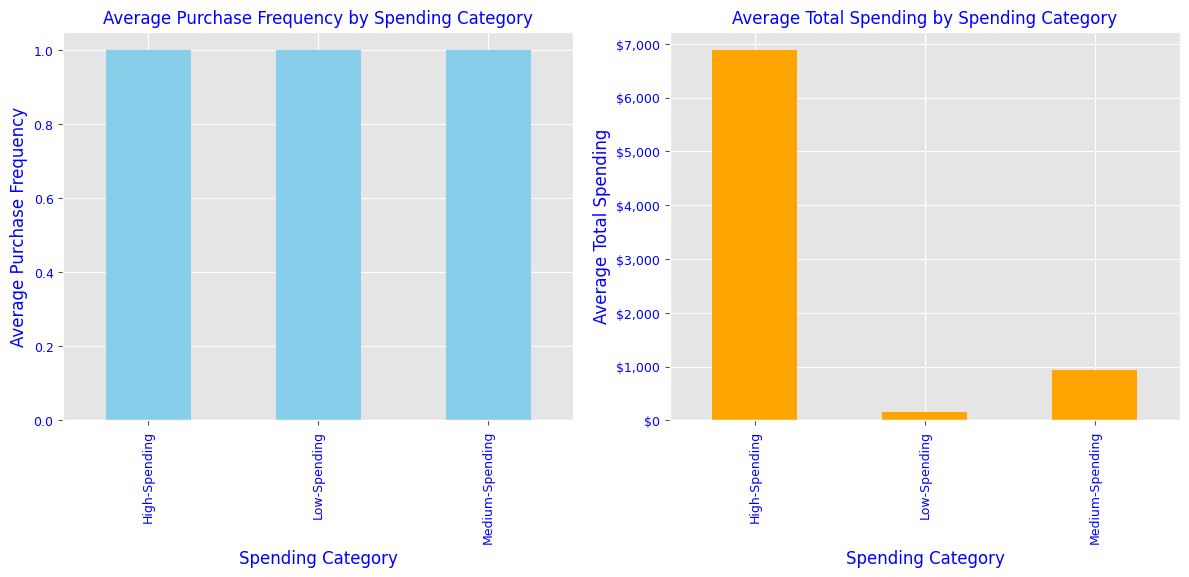

In [19]:
# total spending and purchase frequency for each customer
customer_data = data.groupby('customer_id').agg(
                total_spending=('total_revenue', 'sum'),
                purchase_frequency=('invoice_no', 'nunique')
            ).reset_index()

# high-spending and low-spending customer thresholds

high_spending_threshold = 2000  
low_spending_threshold = 500  

# high-spending, medium-spending, and low-spending customers
def categorize_spending(row):
    if row['total_spending'] >= high_spending_threshold:
        return 'High-Spending'
    elif row['total_spending'] <= low_spending_threshold:
        return 'Low-Spending'
    else:
        return 'Medium-Spending'

customer_data['spending_category'] = customer_data.apply(categorize_spending, axis=1)

# average purchase frequency for each spending category
avg_purchase_frequency = customer_data.groupby('spending_category')['purchase_frequency'].mean()

# average total spending for each spending category
avg_total_spending = customer_data.groupby('spending_category')['total_spending'].mean()

# bar plots to visualize the differences
plt.figure(figsize=(12, 6))

# Purchase frequency comparison
plt.subplot(1, 2, 1)
avg_purchase_frequency.plot(kind='bar', color='skyblue')
plt.title("Average Purchase Frequency by Spending Category",color='blue', fontsize=12)
plt.xlabel("Spending Category",color='blue', fontsize=12)
plt.ylabel("Average Purchase Frequency",color='blue', fontsize=12)
plt.tight_layout()
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')

# Total spending comparison
plt.subplot(1, 2, 2)
avg_total_spending.plot(kind='bar', color='orange')
plt.title("Average Total Spending by Spending Category",color='blue', fontsize=12)
plt.xlabel("Spending Category",color='blue', fontsize=12)
plt.ylabel("Average Total Spending",color='blue', fontsize=12)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

**Observation**: 

- Since the data doesnt have customers who purchased items more than once, their spending frequency is the same for each category, that is 1. 


- Its notable that customers in high-spending category has very high average total spending. This also follows the fact that, no customer in the lower spending categories purchased items multiple times within the period.